
# Reinforcement Learning on a Gridworld Environment

This code implements a basic reinforcement learning agent using Q-learning to navigate a gridworld environment. 

The environment consists of a grid of rewards, with the agent starting in the top left corner. The goal is to navigate to the highest reward states.



## Importing Libraries

First we import the necessary libraries:

In [49]:
from environment import GridEnv
import utils
import pandas as pd
import time
import numpy as np

- `GridEnv` contains the gridworld environment class
- `utils` contains some helper functions
- `pandas` is used to load in the grid data
- `time` will be used to track runtime
- `numpy` provides array operations and math functions

## Initializing the Environment

Next we set up the environment:

In [50]:
grid = pd.read_excel("Grid.xlsx", header=None)
rewards_grid = grid.values
rewards_grid = rewards_grid[::-1]  # Reverse the grid to match the environment's coordinate system

env = GridEnv(rewards_grid)
env.reset()

(0, {'distance': -58})

- We load the grid data from an Excel file into a Pandas DataFrame
- Extract the values into a NumPy array
- Reverse the array so it matches the (y,x) coordinate system of the environment
- Create a GridEnv instance, passing in the grid of rewards
- Reset the environment twice to start from the initial state

## Defining Parameters

Now we define some key parameters:

In [51]:
env.reset()

state_size = env.observation_space.n
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: 900
Number of actions: 2


- `state_size`: The number of states in the environment
- `num_actions`: The number of possible actions the agent can take

We print these to confirm the environment setup.

## Initializing Q-values

The core of Q-learning is maintaining a table of Q-values for each state-action pair. We initialize this table to zeros:

In [52]:
Q = np.zeros((state_size, num_actions))

## Defining Algorithm Parameters

We also define some key parameters for the Q-learning algorithm:

In [53]:
GAMMA = 0.9999      # discount factor
ALPHA = 0.9         # learning rate 
E_GREEDY = True     # Wether to follow an e-greedy policy at first

- `GAMMA`: Discount factor for future rewards
- `ALPHA`: Learning rate for updating Q-values
- `E_GREEDY`: Whether to use an epsilon-greedy policy for action selection

## Define the Q-value Update Function

We define the function `updated_q` that updates the Q-value using the Q-learning update rule.

In [54]:
def updated_q(q, state, action, next_state, reward, done, 
             alpha=ALPHA, gamma=GAMMA):
    
    max_qs = np.max(q[next_state,:])
    estimated_qs = reward + gamma * max_qs * (1 - done)
    
    q_value = q[state, action]
    updated_qs = utils.lerp(q_value, estimated_qs, alpha)
    
    return updated_qs


The Bellman equation gives us the relationship between Q-values:

$$Q(s,a) = r + \gamma \max_{a'} Q(s', a')$$

Where:

- $Q(s,a)$ is the Q-value for state $s$ and action $a$
- $r$ is the immediate reward
- $\gamma$ is the discount factor
- $\max_{a'} Q(s', a')$ is the max Q-value for the next state $s'$

We use this to get an estimated Q-value:

Then we do a soft update between the old Q-value and the estimated Q-value:

$$Q(s,a) \leftarrow (1 - \alpha) Q(s,a) + \alpha (r + \gamma \max_{a'} Q(s', a'))$$

Where $\alpha$ is the learning rate.

By using a soft update, the Q-values slowly converge towards the optimal values.

## Training the Agent

We train the agent using Q-learning. The main training loop runs for a specified number of episodes, and within each episode, the agent interacts with the environment to update the Q-table.

In [55]:
start = time.time()

num_episodes = 10_000
max_num_timesteps = 10000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

k = num_episodes

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state, _  = env.reset()
    total_points = 0
    total_points += rewards_grid[0, 0] # count the points in the first time step
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        q_values = Q[state, :]
        
        action = utils.get_action(q_values, epsilon = epsilon if E_GREEDY else 0 )
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        
        q_values[action] = updated_q(Q, state=state, action=action ,next_state=next_state, reward=reward, done=done)
        
        Q[state, :] = q_values
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 380 points in the last 100 episodes.
    if av_latest_points >= 380:
        k = i + 1
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        break

Episode 31 | Total point average of the last 100 episodes: -744.90

Episode 100 | Total point average of the last 100 episodes: -805.65
Episode 200 | Total point average of the last 100 episodes: -667.28
Episode 300 | Total point average of the last 100 episodes: -387.73
Episode 400 | Total point average of the last 100 episodes: -161.95
Episode 500 | Total point average of the last 100 episodes: -154.26
Episode 600 | Total point average of the last 100 episodes: -0.3163
Episode 700 | Total point average of the last 100 episodes: 37.72
Episode 800 | Total point average of the last 100 episodes: 58.87
Episode 900 | Total point average of the last 100 episodes: 83.807
Episode 1000 | Total point average of the last 100 episodes: 97.81
Episode 1100 | Total point average of the last 100 episodes: 165.21
Episode 1200 | Total point average of the last 100 episodes: 187.60
Episode 1300 | Total point average of the last 100 episodes: 227.40
Episode 1400 | Total point average of the last 100 episodes: 239.36
Episode 1500 | Total point average of the last 100 epi

This code trains the agent through multiple episodes and keeps track of the total points earned in each episode. It also updates the ε-greedy policy and checks if the environment is solved.

This notebook demonstrates how to apply Q-learning to solve a grid-based reinforcement learning problem.

## Results

Finally we print out some results:


Total Runtime: 7.04 s (0.12 min)

Maximum points achieved: 383


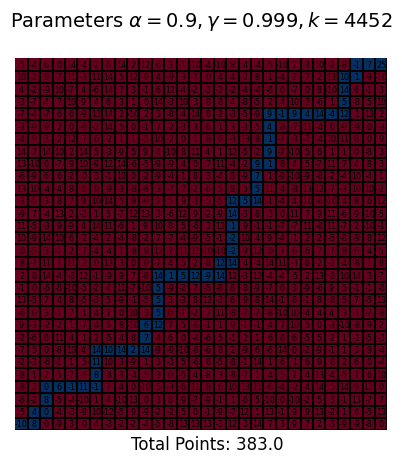

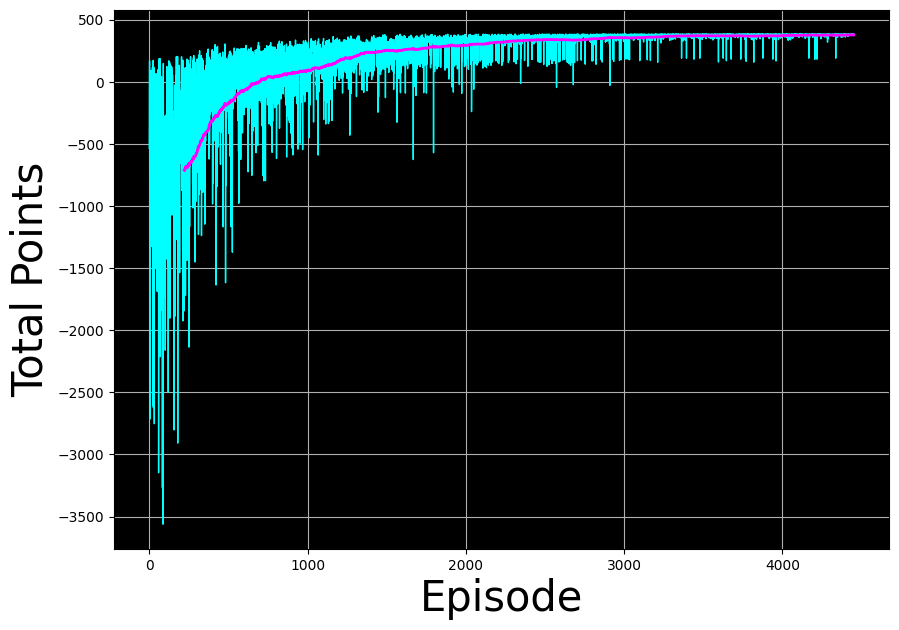

In [56]:
tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)") 
max = np.max(total_point_history)
print(f"\nMaximum points achieved: {max}")

# Plot the total point history along with the moving average
env.render(ALPHA, GAMMA, k)
utils.plot_history(total_point_history)

# utils.plot_q_values(Q, rewards_grid[::-1])

- Print total runtime
- Render environment visualization
- Plot reward history
- Could also plot Q-values

This shows a basic implementation of Q-learning on a simple gridworld environment. The agent is able to learn an effective policy to navigate to high reward states.